# Ch08. 텍스트분석 실습 #8

**Ch08-10. 캐글 Mercari Price Suggetion Challenge**

* https://www.kaggle.com/c/mercari-price-suggetion-challenge/data 에서train.tsv.7z 파일의 압축을 풀어 train.tsv파일 사용
* 일본 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격 예측하는 과제
* 데이터 셋은 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터로 구성

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
/kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z
/kaggle/input/mercari-price-suggestion-challenge/sample_submission.csv.7z
/kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip
/kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z


In [4]:
pip install py7zr

     |████████████████████████████████| 65 kB 453 kB/s eta 0:00:011
     |████████████████████████████████| 13.7 MB 10.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import py7zr

with py7zr.SevenZipFile('/kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z', mode='r') as z:
    z.extractall()

## **데이터 전처리**

In [6]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [7]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


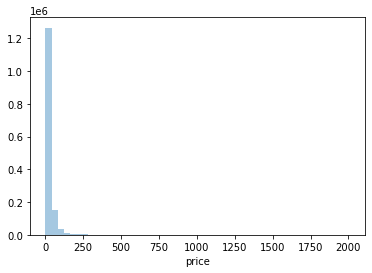

In [8]:
# price column 데이터 분포도 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)

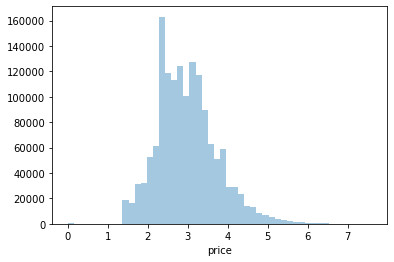

In [9]:
# 로그변환
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

In [10]:
# price칼럼을 로그 변환한 데이터로 대체
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [11]:
# 다른 피처 값 확인
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [12]:
# No description yet 값 확인
boolean_cond = mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

In [13]:
# category_name칼럼에서 대, 중, 소분류 분할하여 리스트로 반환하는 함수 생성
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        # null값인 경우 에러 캐치
        return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

In [14]:
# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


In [15]:
# brand_name, cetegory_name, item_description의 null값을 Other_Null로 변경
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

## **피처 인코딩과 피처 벡터화**

In [16]:
print('brand name의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


* brand name은 대부분 명료한 문자열
* 피처 벡터화 만들 필요없이 원핫 인코딩 변환

In [17]:
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

name 의 종류 갯수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


* 상품명은 유형이 매우 많고 적은 단어 위주의 텍스트 형태이므로 Count기반 피처 벡터화 변환 적용
* category_name은 대, 중, 소 별로 원핫 인코딩 적용
* 배송비 무료여부인 shipping칼럼도 1,2,3,4,5 다섯가지 유형이므로 원핫 인코딩 적용

In [18]:
# 상품에 대한 간단 설명인 item_description
# 평균 문자열 크기과 2개정도의 텍스트만 추출
pd.set_option('max_colwidth', 200)

print('item_description 평균 문자열 개수:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

* 평균 문자열이 145자로 비교적 크므로 TF-IDF변환

In [19]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


In [21]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])


In [22]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


In [23]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 saprse모듈의 hstack함수 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합.
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 셋이 메모를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


105

## **릿지 회귀 모델 구축 및 평가**

**평가 함수 주요 로직**
1. target칼럼은 정규분포로 **로그변환** 되어있음
2. 로그변환된 데이터로 모델은 **예측** 수행
3. 예측된 값은 다시 **지수변환** 수행해서 원상태로!
4. 원복된 데이터로 **RMSLE** 적용

In [24]:
def rmsle(y, y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요. 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

**모델 학습/예측 함수 로직**
1. hstack으로 희소 행렬결합
2. 학습, 평가 데이터셋 생성
3. 모델 학습 및 예측
4. 만든 데이터셋 삭제 후 예측값 반환

In [27]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X = hstack(matrix_list).tocsr()
    
    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],
                                                       test_size=0.2, random_state=156)
    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    del X, X_train, X_test, y_train
    gc.collect()
    
    return preds, y_test

In [28]:
# Ridge를 이용해 회귀 예측 수행
# 수행 전 item_description 속성의 영향도 파악
linear_model = Ridge(solver = "lsqr", fit_intercept=False)
sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5021652473881735
Item Description을 포함한 rmsle 값: 0.4712203733553955


## **LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가**

- LigthGBM이용해 회귀 수행
- 앞서 구한 릿지 모델 예측값과 앙상블로 섞어서 최종 회귀 예측값 평가

In [29]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, 
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimate=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list = sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

LightGBM rmsle 값: 0.46570352970016854


In [30]:
preds = lgbm_preds*0.45 + linear_preds*0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

NameError: name 'evalutate_org_price' is not defined